# Project1: Network Analysis: Centrality Measures

**GROUP: Forhad Akbar, Adam Douglas, and Soumya Ghosh**

For your first project, you are asked to -

 - Identify and load a network dataset that has some categorical information available for each node.
 - For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
 - Compare your centrality measures across your categorical groups.

## Data Description: The political blogosphere network

The network of political blogs was first analyzed in “The political blogosphere and the 2004 US Election” by Lada A. Adamic and Natalie Glance, in Proceedings of the WWW-2005 Workshop on the Weblogging Ecosystem (2005). This data set, collected before the 2004 American presidential election, records hyperlinks connecting political blogs to one another. These blogs have been labeled manually as either “liberal” or “conservative”. 

Node "value" attributes indicate political leaning according to:

  - 0 (left or liberal)
  - 1 (right or conservative)

Data on political leaning comes from blog directories as indicated.  Some blogs were labeled manually, based on incoming and outgoing links and posts around the time of the 2004 presidential election.  Directory-derived labels are prone to error; manual labels even more so.

Links between blogs were automatically extracted from a crawl of the front page of the blog.

## Objective
We are aiming to analyze and find answers to below questions leveraging this dataset -

1. Which category is more represented in the data (e.g. simple count of nodes in each category)
2. Which Website(s) are the major sources for these blog posts? 
3. Which node(s) have a higher incoming degree centrality by category (i.e. more popular, therefore quoted more)
4. Which node(s) in each category have higher degree centrality from the opposite category (i.e. a liberal blog quoting a conservative blog)
5. Most popular platforms by category (e.g. Blogspot, AmericanPolitics.com, etc.)
6. Most influential nodes by category (Eigenvector Centrality)
7. Highest out-degrees (who is more prolific in linking to other blogs)
8. Any interesting subnetworks we may discover

## Import Python Packages

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from pyvis import network as net
import matplotlib.pyplot as plt
import seaborn as sns
# create number for each group to allow use of colormap
from itertools import count, groupby
import collections

%matplotlib inline
sns.set()

## Load Political Blogs dataset

In [2]:
G = nx.read_gml(path="Dataset/polblogs.gml")

print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 1490
Number of edges: 19090
Average in degree:  12.8121
Average out degree:  12.8121


## Print first 10 nodes of the graph

Let's start our analysis with a preview of first 10 blog post entries in the dataset -

In [3]:
list(G.nodes.data())[1:10]

[('12thharmonic.com/wordpress', {'value': 0, 'source': 'BlogCatalog'}),
 ('40ozblog.blogspot.com', {'value': 0, 'source': 'Blogarama,BlogCatalog'}),
 ('4lina.tblog.com', {'value': 0, 'source': 'Blogarama'}),
 ('750volts.blogspot.com', {'value': 0, 'source': 'Blogarama'}),
 ('95theses.blogspot.com', {'value': 0, 'source': 'Blogarama'}),
 ('abbadabbaduo.blogspot.com',
  {'value': 0, 'source': 'Blogarama,LeftyDirectory'}),
 ('aboutpolitics.blogspot.com',
  {'value': 0, 'source': 'Blogarama,eTalkingHead'}),
 ('achingandspinning.blogspot.com', {'value': 0, 'source': 'Blogarama'}),
 ('ackackack.com', {'value': 0, 'source': 'BlogCatalog'})]

From the sample records above, we can see that there are two categorical attributes present in the dataset -
 - **'value'**: The political view type in the blog post (0 - Left/Liberal & 1 - Right/Conservative).
 - **'source'**: The Blog platform where the post was sourced from. 

## Assigning the 'color' attribute to nodes
Next, we are going to add a color attribute for each blogpost node as an additional attribute.


In [4]:
node_list = list(G.nodes())
types = list(nx.get_node_attributes(G,'value').values())

df_col = pd.DataFrame(types, columns = ['type'])
df_col['color'] = np.where(df_col['type'] == 0, "blue", "red")

# Create dictionary object to add the color for each node
color_dict = { k:v for k,v in zip(node_list,list(df_col['color']))}
color_dict
nx.set_node_attributes(G, color_dict, 'color')

# Confirm the addition of 'color' attribute to the graph nodes
list(G.nodes.data())[1:10]

[('12thharmonic.com/wordpress',
  {'value': 0, 'source': 'BlogCatalog', 'color': 'blue'}),
 ('40ozblog.blogspot.com',
  {'value': 0, 'source': 'Blogarama,BlogCatalog', 'color': 'blue'}),
 ('4lina.tblog.com', {'value': 0, 'source': 'Blogarama', 'color': 'blue'}),
 ('750volts.blogspot.com',
  {'value': 0, 'source': 'Blogarama', 'color': 'blue'}),
 ('95theses.blogspot.com',
  {'value': 0, 'source': 'Blogarama', 'color': 'blue'}),
 ('abbadabbaduo.blogspot.com',
  {'value': 0, 'source': 'Blogarama,LeftyDirectory', 'color': 'blue'}),
 ('aboutpolitics.blogspot.com',
  {'value': 0, 'source': 'Blogarama,eTalkingHead', 'color': 'blue'}),
 ('achingandspinning.blogspot.com',
  {'value': 0, 'source': 'Blogarama', 'color': 'blue'}),
 ('ackackack.com', {'value': 0, 'source': 'BlogCatalog', 'color': 'blue'})]

## Visualizing the graph dataset -

In [5]:
n = net.Network(height = "800px", width = "100%", notebook = True, 
                bgcolor = "#ffffff", font_color = "black",
                heading = 'Political Blogosphere Graph Analysis', directed = True)
nx_graph = nx.Graph(G)
#print(type(nx_graph))
n.from_nx(nx_graph, default_node_size = 50, default_edge_weight = 1)
#n.enable_physics(True)
neighbor_map = n.get_adj_list()

# add neighbor data to node hover data
for node in n.nodes:
    node["label"] += " Neighbors:<br>" + \
           "<br>".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])
    
n.show_buttons(filter_=['physics'])
n.show("graph.html")

## Distribution of political views in the dataset
We wanted to start off our data anlaysis with a quick view of distribution of political views in blog possts dataste -

In [29]:
## Count of nodes by 'value' attribute
types = list(nx.get_node_attributes(nx_graph,'value').values())
type_counter=collections.Counter(types)
df = pd.DataFrame.from_dict(type_counter, orient='index').reset_index()
df = df.rename(columns={'index':'type', 0:'count'})
df['category'] = np.where(df['type'] == 0, "Left/Liberal", "Right/Conservative")
df

,type,count,category
0,0,758,Left/Liberal
1,1,732,Right/Conservative


From the table above, it can be be inferred that the dataset is pretty much evenly balanced between two opposing political views with 'Left/Liberal' having little more posts.

## Distribution of Blog Posts Sources
We wanted to quickly analyze which blogging platforms are the major sources for the political blog posts dataset. So we identified top 10 sources below -


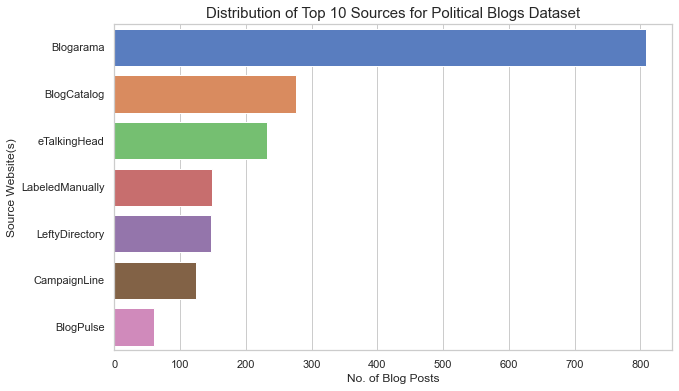

In [18]:
## Count of nodes by 'value' attribute
source = list(nx.get_node_attributes(nx_graph,'source').values())

# Some have mutiple entries, and we will split them out and count each one
source = [item.split(",") for item in source]
source = [item for sublist in source for item in sublist]

source_counter=collections.Counter(source)
df1 = pd.DataFrame.from_dict(source_counter, orient='index').reset_index()
df1 = df1.rename(columns={'index':'source', 0:'count'})
#df['category'] = np.where(df['type'] == 0, "Left/Liberal", "Right/Conservative")
df1 = df1.nlargest(10,'count')

#Seaborn barplot
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x = 'count', y = df1.source, data=df1, ci=None, palette="muted",orient='h', )
ax.set_title("Distribution of Top 10 Sources for Political Blogs Dataset", fontsize=15)
ax.set_xlabel ("No. of Blog Posts")
ax.set_ylabel ("Source Website(s)")


bar.savefig("Seaborn_Pie_Chart.png");

Based on the bar chart above, we can clearly see blogarama ([link](https://www.blogarama.com/)) is the major source for the blog entries. 

## Neighbor Analysis & Centrality:
Centrality is the measure of closeness of a node to the center(s) of high activity in a network and implies the structural importance of the node in the network. Centrality can be measured by **degree**, **closeness** and **betweenness**.

In [31]:
counts = [(n, len(list(G.neighbors(n)))) for n in G.nodes()]
counts = sorted(counts, key = lambda x: x[1], reverse = True)

print("The most connected blog post is from '", str(counts[0][0]), "' with ", str(counts[0][1]), " neighbors.", sep="")

The most connected blog post is from 'blogsforbush.com' with 256 neighbors.


### Degree centrality: 
Next we compute the degree centrality for political blog nodes. *Degree* is the direct count of the number of connections a node has to other nodes. A higher degree value compared to peers denotes higher influence in the network. The degree centrality values are normalized by dividing by the maximum possible degree in a simple graph $n-1$ where $n$ is the number of nodes in $G$.

In [24]:
degree_list = list(nx.degree_centrality(G).items())
df_degree = pd.DataFrame(degree_list, columns = ["Blogsite","Degree_Centrality"])

# Get top 10 
sorted(degree_list, key = lambda x: x[1], reverse = True)[:10]

[('instapundit.com', 0.5284178187403994),
 ('blogsforbush.com', 0.4946236559139785),
 ('atrios.blogspot.com', 0.4869431643625192),
 ('dailykos.com', 0.45622119815668205),
 ('talkingpointsmemo.com', 0.3640552995391705),
 ('washingtonmonthly.com', 0.35944700460829493),
 ('hughhewitt.com', 0.3317972350230415),
 ('powerlineblog.com', 0.3271889400921659),
 ('michellemalkin.com', 0.3195084485407066),
 ('wizbangblog.com', 0.31336405529953915)]

The blogpost from **"blogsforbush.com"** has the maximum degree centrality.

Next, we also wanted to analyze **In** and **Out** degree centrality of blog posts to identify importance or relevance of specific blog posts within the community of political bloggers.

### In-Degree Centrality
Blog posts with high in-degree centrality gain attention to their posts among the community of bloggers who participate in the conversation. In-degree centrality, thus, captures the blogger community's level of engagement or attenstion with specific blog posts. Those with high in-degree centrality scores can be thought of as conversational hubs, since other bloggers have mentioned, or provided citation for their posts. In-degree centrality, therefore, is an indication of the cascades of information flow initiated by a blogpost. 

In [25]:
in_degree_list = list(nx.in_degree_centrality(G).items())
df_in_degree = pd.DataFrame(in_degree_list, columns = ["Blogsite","In_Degree_Centrality"])

# Get top 10 
sorted(in_degree_list, key = lambda x: x[1], reverse = True)[:10]

[('instapundit.com', 0.39631336405529954),
 ('dailykos.com', 0.38556067588325654),
 ('atrios.blogspot.com', 0.3533026113671275),
 ('talkingpointsmemo.com', 0.34408602150537637),
 ('powerlineblog.com', 0.30414746543778803),
 ('michellemalkin.com', 0.2764976958525346),
 ('washingtonmonthly.com', 0.2749615975422427),
 ('drudgereport.com', 0.2626728110599078),
 ('littlegreenfootballs.com/weblog', 0.2519201228878648),
 ('truthlaidbear.com', 0.2519201228878648)]

### Out-Degree Centrality
Out-degree centrality captures the outreach of a blogpost to the blogger's community. A high out-degree centrality value indicates that a blogger is aiming to reach bloggers' attention by mentioning or replying to their posts. Out-degree centrality, then, captures the level of engagement a blogger initiates through a specific post with members of the community.

In [26]:
out_degree_list = list(nx.out_degree_centrality(G).items())
df_out_degree = pd.DataFrame(out_degree_list, columns = ["Blogsite","Out_Degree_Centrality"])

# Get top 10 
sorted(out_degree_list, key = lambda x: x[1], reverse = True)[:10]

[('blogsforbush.com', 0.25499231950844853),
 ('madkane.com/notable.html', 0.19047619047619047),
 ('politicalstrategy.org', 0.1827956989247312),
 ('cayankee.blogs.com', 0.17204301075268819),
 ('newleftblogs.blogspot.com', 0.17050691244239632),
 ('presidentboxer.blogspot.com', 0.16129032258064516),
 ('liberaloasis.com', 0.1597542242703533),
 ('corrente.blogspot.com', 0.15821812596006143),
 ('lashawnbarber.com', 0.15360983102918588),
 ('techievampire.net/wppol', 0.1490015360983103)]

### Eigen Vector Centrality:
Like degree centrality, EigenCentrality measures a node’s influence based on the number of links it has to other nodes in the network. EigenCentrality then goes a step further by also taking into account how well connected a node is, and how many links their connections have, and so on through the network. By calculating the extended connections of a node, EigenCentrality can identify nodes with influence over the whole network, not just those directly connected to it.

In [27]:
eigen_list = list(nx.eigenvector_centrality(nx_graph).items())
df_eigen = pd.DataFrame(eigen_list, columns = ["Blogsite","Eigen_Centrality"])

# Get top 10 
sorted(eigen_list, key = lambda x: x[1], reverse = True)[:10]

[('dailykos.com', 0.1642143693627572),
 ('atrios.blogspot.com', 0.16052448104611833),
 ('talkingpointsmemo.com', 0.14928287200165583),
 ('washingtonmonthly.com', 0.13963574133398254),
 ('liberaloasis.com', 0.11899194064802122),
 ('digbysblog.blogspot.com', 0.11787380919996894),
 ('instapundit.com', 0.11336959967061194),
 ('bodyandsoul.typepad.com', 0.11121461467217228),
 ('pandagon.net', 0.10814134579414941),
 ('talkleft.com', 0.10740515466131434)]

It's interesting to find similarity in the resultsets between **In-degree** and **EigenCentrality** for identofying most influential blogposts.

### Closeness Centrality: 
Closeness centrality indicates how close a node is to all other nodes in the network. It is calculated as the average of the shortest path length from the node to every other node in the network.

The closeness centrality is normalized to $\frac{(n-1)}{(\lvert G \rvert -1)}$ where $n$ is the number of nodes in the connected part of graph containing the node. If the graph is not completely connected, this algorithm computes the closeness centrality for each connected part separately.

In [28]:
closeness_list = list(nx.closeness_centrality(G).items())
df_close = pd.DataFrame(closeness_list, columns = ["Blogsite","Closeness_Centrality"])

# Get top 10 
sorted(closeness_list, key = lambda x: x[1], reverse = True)[:10]

[('instapundit.com', 0.5857898715041572),
 ('dailykos.com', 0.5710601455282306),
 ('talkingpointsmemo.com', 0.5482601582880134),
 ('atrios.blogspot.com', 0.54673721340388),
 ('powerlineblog.com', 0.5407291121576835),
 ('washingtonmonthly.com', 0.5319605319605318),
 ('michellemalkin.com', 0.5152497299094158),
 ('truthlaidbear.com', 0.5134575569358177),
 ('nationalreview.com/thecorner', 0.5125661375661376),
 ('drudgereport.com', 0.5085927566547721)]

The blogpost from **"dailykos.com"** has the maximum closeness centrality.

## Summary of Centrality Scores
We summarized all our centrality scores and sorted by **degree centrality** to show top 10 blog posts.

In [38]:
from functools import reduce

dfs = [df_degree, df_in_degree, df_out_degree, df_eigen, df_close]
df_final = reduce(lambda left,right: pd.merge(left,right,on='Blogsite'), dfs)

df_final['Blog_Rank'] = df_final['Degree_Centrality'].rank(ascending=False)
df_final.sort_values(by=['Blog_Rank']).head(10)

,Blogsite,Degree_Centrality,In_Degree_Centrality,Out_Degree_Centrality,Eigen_Centrality,Closeness_Centrality,Blog_Rank
429,instapundit.com,0.528418,0.396313,0.132104,0.113370,0.585790,1.0
329,blogsforbush.com,0.494624,0.239631,0.254992,0.051809,0.460590,2.0
22,atrios.blogspot.com,0.486943,0.353303,0.133641,0.160524,0.546737,3.0
60,dailykos.com,0.456221,0.385561,0.070661,0.164214,0.571060,4.0
239,talkingpointsmemo.com,0.364055,0.344086,0.019969,0.149283,0.548260,5.0
269,washingtonmonthly.com,0.359447,0.274962,0.084485,0.139636,0.531961,6.0
424,hughhewitt.com,0.331797,0.227343,0.104455,0.068051,0.491245,7.0
522,powerlineblog.com,0.327189,0.304147,0.023041,0.074305,0.540729,8.0
479,michellemalkin.com,0.319508,0.276498,0.043011,0.068295,0.515250,9.0
648,wizbangblog.com,0.313364,0.199693,0.113671,0.058403,0.471250,10.0


# Liberal and Conservative blogs
We will divide the network into its liberal and conservative blogs, and run this algorithm seperately:

In [21]:
# Liberal subgraph
liberal = [n for n,v in G.nodes(data=True) if v['value'] == 0]  
G_liberal = G.subgraph(liberal)
nx_graph_lib = nx.Graph(G_liberal)

# Conservative subgraph
conservative = [n for n,v in G.nodes(data=True) if v['value'] == 1]  
G_conservative = G.subgraph(conservative)
nx_graph_cons = nx.Graph(G_conservative)

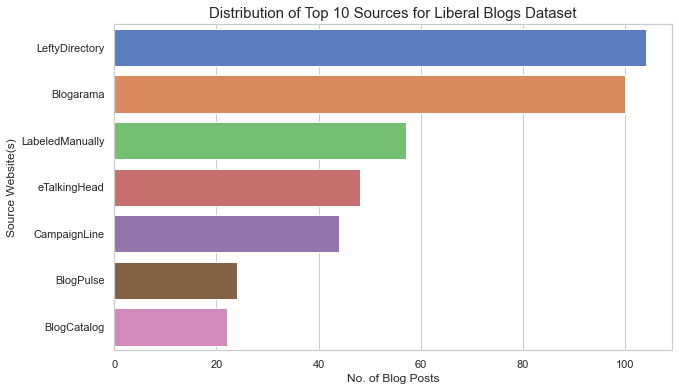

In [22]:
## Count of nodes by 'value' attribute
liberal_source = list(nx.get_node_attributes(nx_graph_lib,'source').values())

# Some have mutiple entries, and we will split them out and count each one
liberal_source = [item.split(",") for item in liberal_source]
liberal_source = [item for sublist in liberal_source for item in sublist]

liberal_source_counter=collections.Counter(liberal_source)
df_liberal = pd.DataFrame.from_dict(liberal_source_counter, orient='index').reset_index()
df_liberal = df_liberal.rename(columns={'index':'source', 0:'count'})
#df['category'] = np.where(df['type'] == 0, "Left/Liberal", "Right/Conservative")
df_liberal = df_liberal.nlargest(10,'count')

#Seaborn barplot
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x = 'count', y = df_liberal.source, data=df_liberal, ci=None, palette="muted",orient='h', )
ax.set_title("Distribution of Top 10 Sources for Liberal Blogs Dataset", fontsize=15)
ax.set_xlabel ("No. of Blog Posts")
ax.set_ylabel ("Source Website(s)")


bar.savefig("Seaborn_Liberal_Bar.png");

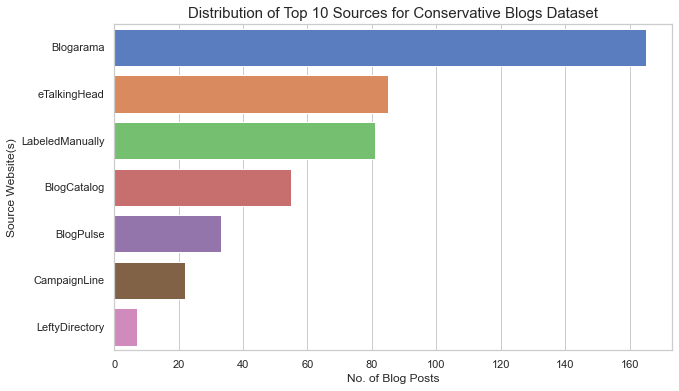

In [23]:
## Count of nodes by 'value' attribute
cons_source = list(nx.get_node_attributes(nx_graph_cons,'source').values())

# Some have mutiple entries, and we will split them out and count each one
cons_source = [item.split(",") for item in cons_source]
cons_source = [item for sublist in cons_source for item in sublist]


cons_source_counter=collections.Counter(cons_source)
df_cons = pd.DataFrame.from_dict(cons_source_counter, orient='index').reset_index()
df_cons = df_cons.rename(columns={'index':'source', 0:'count'})
#df['category'] = np.where(df['type'] == 0, "Left/Liberal", "Right/Conservative")
df_cons = df_cons.nlargest(10,'count')

#Seaborn barplot
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x = 'count', y = df_cons.source, data=df_cons, ci=None, palette="muted",orient='h', )
ax.set_title("Distribution of Top 10 Sources for Conservative Blogs Dataset", fontsize=15)
ax.set_xlabel ("No. of Blog Posts")
ax.set_ylabel ("Source Website(s)")


bar.savefig("Seaborn_Conservative_Bar.png");

Based on the above analysis, we can see that most popular political bloggiong platforms hosted both liberal and conservative blog posts. **Blogarama** showed up as one of the most popular in both the categories.

In [21]:
# measure of node’s centrality: liberal
closeness_list_liberal = list(nx.closeness_centrality(G_liberal).items())

# Get top 10 
sorted(closeness_list_liberal, key = lambda x: x[1], reverse = True)[:10]

[('dailykos.com', 0.4370256879099083),
 ('atrios.blogspot.com', 0.4094114274101064),
 ('talkingpointsmemo.com', 0.3952937919821717),
 ('juancole.com', 0.34657153390064815),
 ('washingtonmonthly.com', 0.3410200447992648),
 ('talkleft.com', 0.33488934736467124),
 ('digbysblog.blogspot.com', 0.3300681275244268),
 ('pandagon.net', 0.3289751867048096),
 ('prospect.org/weblog', 0.3268108762659621),
 ('thismodernworld.com', 0.3211762059855145)]

In [22]:
# measure of node’s centrality: conservative
closeness_list_conservative = list(nx.closeness_centrality(G_conservative).items())

# Get top 10 
sorted(closeness_list_conservative, key = lambda x: x[1], reverse = True)[:10]

[('drudgereport.com', 0.4236693780099153),
 ('instapundit.com', 0.4230843680004424),
 ('blogsforbush.com', 0.41134561096921635),
 ('powerlineblog.com', 0.4025044722719141),
 ('littlegreenfootballs.com/weblog', 0.39186558754226003),
 ('michellemalkin.com', 0.3892931657422014),
 ('hughhewitt.com', 0.3749356728012351),
 ('captainsquartersblog.com/mt', 0.3698689745201373),
 ('nationalreview.com/thecorner', 0.3683374259713997),
 ('lashawnbarber.com', 0.36419033110375854)]

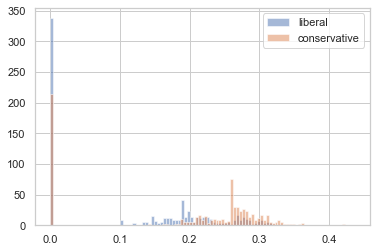

In [23]:
lib_centrality = [i[1] for i in closeness_list_liberal]
con_centrality = [i[1] for i in closeness_list_conservative]

plt.hist(lib_centrality, 100, alpha=0.5, label='liberal')
plt.hist(con_centrality, 100, alpha=0.5, label='conservative')
plt.legend(loc='upper right')

## Focused Analysis
To focus in on the more prominent blogs, we filtered out blogs which have less than 12 links either to or from them. After filtering, there are 652 blogs and 16,787 links between them.

In [39]:
remove = [node for node,degree in dict(G.degree()).items() if degree < 12]
G.remove_nodes_from(remove)
print(nx.info(G))


Name: 
Type: MultiDiGraph
Number of nodes: 652
Number of edges: 16787
Average in degree:  25.7469
Average out degree:  25.7469


In [16]:
# Drawing graph for prominent blogs only
n_new = net.Network(height = "800px", width = "100%", notebook = True, 
                bgcolor = "#ffffff", font_color = "black",
                heading = 'Political Blogosphere Focused Analysis', directed = True)
nx_graph_new = nx.Graph(G)
n_new.from_nx(nx_graph_new, default_node_size = 10, default_edge_weight = 1)
neighbor_map = n_new.get_adj_list()
    
n_new.show("graph_new.html")

Based on above focused analysis with more prominent blog posts, we observed that some of the conservative blog posts like **Windingroad.typead.com** were having inbound references from multiple liberal blog posts.

## Reference:

1. [The Political Blogosphere and the 2004 U.S. Election: Divided They Blog. Lada A. Adamic.](https://edisciplinas.usp.br/pluginfile.php/3333574/mod_resource/content/2/p36-adamic.pdf)
2. [Visualizing Polarization in Political Blogs](http://allthingsgraphed.com/2014/10/09/visualizing-political-polarization/)